In [1]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

from scipy.interpolate import interp1d

In [2]:
FIG_DIR = "/home/kieran/Level5ProjectAudioVAE/src/evaluation/figures/latent_controller"

In [3]:
sns.set(style='white')

In [30]:
od_df = pd.read_csv("/home/kieran/Level5ProjectAudioVAE/src/evaluation/data/latent_controller/overdrive.csv")
mb_df = pd.read_csv("/home/kieran/Level5ProjectAudioVAE/src/evaluation/data/latent_controller/multiband.csv")

In [31]:
def get_nearest_point(x: float, y: float, df: pd.DataFrame):
    data = np.array([df[f'x_emb_n=0'], df[f'y_emb_n=0']]).T
    point = np.array([x, y])
    dists = np.linalg.norm(data - point, axis=1)
    return np.argmin(dists)

In [32]:
def get_min_max(df: pd.DataFrame, col: str):
    idx_min = df[col].argmin()
    idx_max = df[col].argmax()
    return idx_min, idx_max

In [33]:
def get_start_end(df, start_idx, end_idx):
    x0 = df.iloc[start_idx]['x_emb_n=0']
    y0 = df.iloc[start_idx]['y_emb_n=0']
    
    x1 = df.iloc[end_idx]['x_emb_n=0']
    y1 = df.iloc[end_idx]['y_emb_n=0']
    
    return x0, y0, x1, y1

In [34]:
def get_linear_interpolation(df, start_idx, end_idx):
    x0, y0, x1, y1 = get_start_end(df, start_idx, end_idx)
    
    return np.linspace(start=[x0, y0], stop=[x1, y1], num=100)

In [35]:
def get_param_df_interpolation(df, lin, param_names):
    params = []

    for point in lin:
        idx = get_nearest_point(point[0], point[1], df)
        row = df.iloc[idx]
        row_params = row[param_names]
        params.append(row_params.values)
        
    return pd.DataFrame(np.array(params), columns=param_names)

In [36]:
def get_midpoint(df, idx_1, idx_2):
    x1 = df.iloc[idx_1][f'x_emb_n=0']
    y1 = df.iloc[idx_1][f'y_emb_n=0']

    x2 = df.iloc[idx_2][f'x_emb_n=0']
    y2 = df.iloc[idx_2][f'y_emb_n=0']

    x_mid = (x1 + x2) / 2
    y_mid = (y1 + y2) / 2

    return x_mid, y_mid

In [37]:
def get_indices(df, df_col):
    idx_min, idx_max = get_min_max(df, df_col)
    x_mid, y_mid = get_midpoint(df, idx_min, idx_max)
    idx_mid = get_nearest_point(x_mid, y_mid, df)

    return idx_min, idx_mid, idx_max

In [38]:
def plot_column_interpolation(df, df_col):
    params = [col for col in df.columns if 'p_hat' in col]
    idx_min, idx_max = get_min_max(df, df_col)
    lin = get_linear_interpolation(df, idx_min, idx_max)
    
    params_df = get_param_df_interpolation(df, lin, params)
    
    red = sns.color_palette(n_colors=4).as_hex()[3]
    blue = sns.color_palette("pastel", n_colors=4).as_hex()[0]
    fig, ax = plt.subplots(2,1, figsize=(5,5), gridspec_kw={'height_ratios': [1.5, 1]})
    
    sns.scatterplot(df, x='x_emb_n=0', y='y_emb_n=0', ax=ax[0], alpha=1, c=blue)
    x0, y0, x1, y1 = get_start_end(df, idx_min, idx_max)
    x_mid, y_mid = get_midpoint(df, idx_min, idx_max)
    ax[0].plot([x0, x1], [y0, y1], color = red)
    
    # annotation of the third point
    ax[0].text(x0,y0-.4,"A", color=red)
    ax[0].text(x_mid,y_mid+.2,"C", color=red)
    ax[0].text(x1+.05,y1-.4,"B", color=red)
    
    ax[0].set_ylabel("")
    ax[0].set_xlabel("")
    ax[0].set_yticks([])
    ax[0].set_xticks([])
    ax[0].axis('off')
    
    # specifying plot coordinates
    xs = [x0, x_mid, x1]
    ys = [y0, y_mid, y1]
    ax[0].scatter(xs, ys, color=red)
#     sns.despine(left=True, bottom=True, right=True)
    
    for param in params:
        x = np.linspace(0,1,len(params_df))
        xnew = np.linspace(0, 1, num=len(params_df)*3, endpoint=True)
        y = params_df[param]
        f_cubic = interp1d(x, y, kind='cubic')
        sns.lineplot(x=xnew, y=f_cubic(xnew), ax=ax[1], label=param.strip('p_hat_'))
        
    
    # specifying plot coordinates
    ax[1].plot((0, 0), (0, 1), scaley = False, linestyle='--', color=red)
    ax[1].plot((0.5, 0.5), (0, 1), scaley = False, linestyle='--', color=red)
    ax[1].plot((1, 1), (0, 1), scaley = False, linestyle='--', color=red)

    ax[1].set_ylabel('Parameter value', fontsize=10)
    ax[1].set_xlabel('Interpolation step', fontsize=10)
    ax[1].set_xticks([0, .5, 1])
    ax[1].set_xticklabels(['A', 'C', 'B'], color=red)
    ax[1].set_ylim([0,1])
    
    ax[1].yaxis.grid(True)
    
    ax[1].legend(loc='best', prop={'size': 10}, ncol=3)
    
    sns.despine(bottom = True, left = True)
    
    plt.tight_layout()
    
    plt.savefig(f"{FIG_DIR}/{df_col}controller.png")

In [42]:
get_indices(od_df, 'p_drive')

(575, 135, 392)

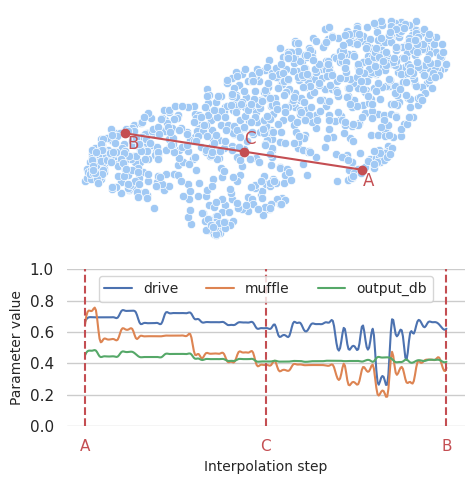

In [43]:
plot_column_interpolation(od_df, 'p_drive')